# Hand-written Digit Classifier with Multilayer Perceptrons

### 1. Imports

In [1]:
%matplotlib notebook


import itertools
import keras
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model

from matplotlib import rcParams
from matplotlib.image import imread
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 
                               'Yu Gothic', 
                               'Meirio', 
                               'Takao', 
                               'IPAexGothic', 
                               'IPAPGothic', 
                               'VL PGothic', 
                               'Noto Sans CJK JP']

from sklearn.metrics import confusion_matrix

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

Using TensorFlow backend.


### 2. Load the MNIST data

In [2]:
(x_train, y_train), (_x_validate, _y_validate) = mnist.load_data()

### 3.  Data preparation

* training dataset: 60,000 images
* validation dataset: 9800 images
* test dataset: 200 images
   * 20 of each digit class

In [3]:
BATCH_SIZE = 128
NUM_CLASSES = 10

# 乱数ジェネレーターをシード
np.random.seed(1234)

num_test_samples_per_class = 20

# validate データをさらに validate / test に分ける
_test_ids = []
for c in [0,1,2,3,4,5,6,7,8,9]:
    _idx = np.random.choice(np.where(_y_validate==c)[0], 
                           size=(num_test_samples_per_class,),
                           replace=False)
    _test_ids.extend(_idx)

# create index masks for validation- and test-sets
_test = np.zeros(_x_validate.shape[0], dtype=bool)
_test[_test_ids] = True
_validate = ~_test

x_validate = _x_validate[_validate, :, :]
y_validate = _y_validate[_validate]

x_test = _x_validate[_test, :, :]
y_test = _y_validate[_test]

# reshape for a flattened input layer 28 x 28 pixels -> 784
x_train = x_train.reshape(x_train.shape[0], 784)
x_validate = x_validate.reshape(x_validate.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# transfrom from 8-bit int value to float in range [0.0, 1.0]
x_train = x_train.astype('float32')
x_validate = x_validate.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_validate /= 255
x_test /= 255
print('Data for Multilayer Perceptron experiment:')
print('  x_train shape: {}'.format(x_train.shape))
print('  x_validate shape: {}'.format(x_validate.shape))
print('  x_test shape: {}'.format(x_test.shape))
print('  {} training samples'.format(x_train.shape[0]))
print('  {} validation samples'.format(x_validate.shape[0]))
print('  {} test samples'.format(x_test.shape[0]))

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_validate = keras.utils.to_categorical(y_validate, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

Data for Multilayer Perceptron experiment:
  x_train shape: (60000, 784)
  x_validate shape: (9800, 784)
  x_test shape: (200, 784)
  60000 training samples
  9800 validation samples
  200 test samples


### 4. Define Multilayer Perceptron model

* define layers
   * input layer: 784 (28x28 pixel image, flattened)
   * 4 hidden layers
      * 32-nodes
      * 64-nodes
      * 128-nodes
      * 256-nodes
   * 10-node output layer (softmax)
   * all layers use ReLU activation, save for the output layer which uses Softmax
* compile
* train across 20 epochs
   * be sure that the loss (training and validation) is decreasing with each epoch
   * also confirm the the accuracy (training and validation) is increasing

In [4]:
model = Sequential()

model.add(Dense(32, input_shape=(784,), activation='relu'))

model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=20,
          shuffle=True,
          verbose=1,
          validation_data=(x_validate, y_validate))

score = model.evaluate(x_validate, y_validate, verbose=0)
print('validation loss: {:.5F}, validation accuracy: {:.5F}'.format(*score))

W0904 22:27:55.105734 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 22:27:55.123458 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 22:27:55.126405 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 22:27:55.206541 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Pl

Train on 60000 samples, validate on 9800 samples
Epoch 1/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.4482 - acc: 0.8544 - val_loss: 0.2063 - val_acc: 0.9363
Epoch 2/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.1721 - acc: 0.9472 - val_loss: 0.1549 - val_acc: 0.9516
Epoch 3/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.1339 - acc: 0.9592 - val_loss: 0.1323 - val_acc: 0.9595
Epoch 4/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.1156 - acc: 0.9649 - val_loss: 0.1372 - val_acc: 0.9579
Epoch 5/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.1012 - acc: 0.9690 - val_loss: 0.1365 - val_acc: 0.9595
Epoch 6/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.0903 - acc: 0.9717 - val_loss: 0.1352 - val_acc: 0.9589
Epoch 7/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.0811 - acc: 0.9745 - val_loss: 0.1160 - val_acc:

### 5. Test the Multilayer Perceptron model on the test data

Use the model on the test dataset.

Display the results in a confusion matrix, with the columns being the predicted class and the rows being the correct class label.

<IPython.core.display.Javascript object>


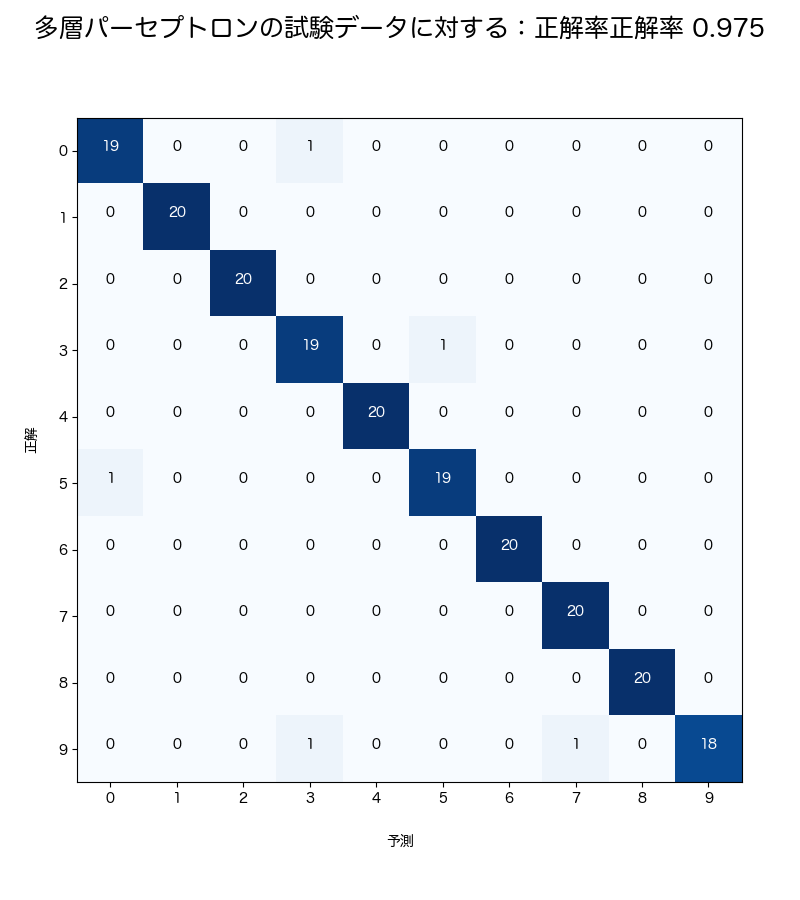

In [5]:
classes = range(10)

_, ax = plt.subplots(1, 1,
                     sharey=True, 
                     figsize=(8,9))

predicted = np.argmax(model.predict(x_test), axis=1)
actual = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(actual, predicted)
    
test_acc = np.sum(predicted==actual) / len(actual)
    
ax.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_xticks(classes)
ax.set_yticks(classes)

thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    ax.text(j, i, confusion_mtx[i, j],
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")

plt.subplots_adjust(top=0.91)
plt.suptitle('多層パーセプトロンの試験データに対する：正解率正解率 {}'.format(test_acc), fontsize=18)
plt.figtext(0.5, 0.06, '予測', fontsize=10, ha='center')
plt.figtext(0.04, 0.5, '正解', fontsize=10, ha='center', rotation=90)
plt.tight_layout(pad=4.2)
plt.show()